In [1]:
#IMPORTAR PACKAGES y LIBRARYS

#Librerías útiles
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
sns.set_theme(style="darkgrid")
from time import strptime
from scipy.signal import periodogram
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.ensemble import IsolationForest

#Modelos de Pruebas Estadísticas
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf
from itertools import combinations
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.stattools as ts

#Modelos predictivos estadísticos
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.linear_model import LinearRegression
#Configuraciones
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
#Funciones Pruebas de hipótesis 
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

def Johan_test(timeseries):
    print ('Results of Johan Cointegration test:')
    kpsstest = coint_johansen(timeseries,-1,1)
    kpssoutput= pd.Series(data=None,index=['eig','max_eig_stat','max_eig_stat_crit_vals','trace_stat','trace_stat_crit_vals'])

    print("eig:",kpsstest.eig)
    print("max_eig_stat:",kpsstest.max_eig_stat)
    print('max_eig_stat_crit_vals:',kpsstest.max_eig_stat_crit_vals)
    print('trace_stat:',kpsstest.trace_stat)
    print('trace_stat_crit_vals:',kpsstest.trace_stat_crit_vals)

def grangres_test(timeseries,column_Y,cols,maxlags):
    print ('Results Grangers Causality test:')
    timeseries= timeseries[cols].dropna()
    first_column=timeseries.pop(column_Y)
    timeseries.insert(0,column_Y,first_column)
    for columna_X in cols:
        if columna_X == column_Y:
            continue
        else:
            print(columna_X)
            test=grangercausalitytests(timeseries[[column_Y, columna_X]], maxlag=maxlags)
            print (test)

def  grangres_test_2(columns, results):
    treshold = 0.05

    # Check if the lags of a quantity help predict its current value 
    for quant in columns:
        
        causality = results.test_causality(quant, quant, kind='f')

        if causality.pvalue < treshold:
            print('{} lags might Granger-cause its current value (NULL HP rejected - pval = {:.4f})'.format(quant, causality.pvalue))
            print('---')

    causally_related = []
            
    # Check if one quantity causes the other
    for quantA, quantB in combinations(columns,2):
        
        bidirectional = [(quantA,quantB),(quantB,quantA)]
        
        for caused, causing in bidirectional:
        
            causality = results.test_causality(caused, causing, kind='f')

            if causality.pvalue < treshold:
                print('{} might Granger-cause {} (NULL HP rejected - pval = {:.4f})'.format(causing, caused, causality.pvalue))
                print('---')
                causally_related.append((causing, caused))


def stationary_test(df,columns,treshold = 0.01):

    for quant in columns:
        
        # Remove null values (useful when plotting diff series)
        time_series = df[quant][df[quant].notnull()]

        # Autocorrelation function
        plot_acf(time_series,title='Autocorrelation function - {}'.format(quant))
        plt.xlabel('lags')
        plt.show()

        # Dickely-Fuller test statistics
        dickley_fuller_test = adfuller(time_series)
        pvalue = dickley_fuller_test[1]

        if pvalue < treshold:
            print('Time series "{}" is stationay (NULL HP rejected - pvalue = {:.4f})'.format(quant,pvalue))
        else:
            print('Time series "{}" might have unit root (NULL HP cannot be rejected - pvalue = {:.4f})'.format(quant,pvalue))

def eg_stat(s1, s2):
    result = ts.coint(s1, s2)
    s = ''
    s+= 'EG Statistic: %.3f\n' % result[0]
    s+= 'p-value: %.3f\n' % result[1]
    s+= 'Critical Values:\n'
    for key, value in zip(['1%', '5%', '10%'], result[2]):
        s += '%s: %.3f\n' % (key, value)
    
    if result[0] < result[2][0]:
        coint = 1
    elif result[2][0] <= result[0] and result[0] <= result[2][2]:
        coint = 2
    else:
        coint = 0
    
    return s, coint

def plot_eg_stat_test(s1,s2, ax):

    s1.plot(ax = ax, legend = s1.name)
    s2.plot(ax = ax, legend = s2.name)
    
    text_color_dict = {0:'red', 1: 'green', 2: 'yellow'}
    s, c_idx = eg_stat(s1, s2)
    
    ax.annotate(s, size=14, color='black', xy=(0.0, 0.6),xycoords='axes fraction',
                   bbox=dict(boxstyle="square,pad=0.3", fc="white", ec=text_color_dict[c_idx], lw=2))
    if c_idx == 0:
        ax.set_title('signals are not cointegrated')
    else:
        ax.set_title('signals are cointegrated')
    ax.grid()

In [3]:
#PREPARACIÓN DATA
dic_mes = {
        'Enero': 1,
        'Febrero': 2,
        'Marzo': 3,
        'Abril':4,
         'Mayo':5,
         'Junio':6,
         'Julio':7,   
         'Agosto':8,
         'Setiembre':9,
         'Octubre':10,
         'Noviembre':11,
         'Diciembre':12
        }

df= pd.read_excel("C:/Users/Usuario/OneDrive - prediqtdata.com/Desktop/Renato/Python/script atenea/consolidado_moderno.xlsx"
,sheet_name="Detergentes")
df.replace(dic_mes, inplace=True)
df['Quarter'] = df['MES'].apply(lambda x: 'Quarter1' if x in [1, 2, 3] else 'Quarter2' if x in [4, 5, 6] else 'Quarter3' if x in [7, 8, 9] else 'Quarter4')
df['Month_in_Quarter'] = df['MES'].apply(lambda x: 1 if x % 3 == 1 else 2 if x % 3 == 2 else 3)
df["PERIODO"]= df["AÑO"].astype(str)+"-"+df["MES"].astype(str)

df['PERIODO'] = pd.to_datetime(df['PERIODO'])    
#df['PERIODO'] = df['PERIODO'].dt.to_period('M')
df = df.set_index('PERIODO')

cols=['AÑO','MES','Quarter','Month_in_Quarter','OFICINA DE VENTAS'
      ,'VENTA SELL IN', 'VENTA SELL OUT TOTAL'
      , 'SHARE VOLUMEN ALICORP', 'SHARE VOLUMEN MERCADO'
      ,'SHARE % ALICORP','SHARE % MERCADO']

cols_data =['VENTA SELL IN'
      , 'VENTA SELL OUT TOTAL'
      #, 'SHARE VOLUMEN ALICORP'
      #,'SHARE VOLUMEN MERCADO'
      #,'SHARE % ALICORP'
      #,'SHARE % MERCADO'
      ]


df_todo=df[cols]
df_out=df[cols_data]



IsolationForest(contamination=0.06)

,AÑO,MES,OFICINA DE VENTAS,VENTA SELL IN,VENTA SELL OUT TOTAL,SHARE VOLUMEN MERCADO,SHARE VOLUMEN ALICORP,SHARE % MERCADO,SHARE % ALICORP,Quarter,Month_in_Quarter,anomaly
PERIODO,,,,,,,,,,,,
2019-01-01,2019,1,MODERNO,2299.000000,1801.000000,2555.520000,2064.93000,NaN,NaN,Quarter1,1,1
2019-02-01,2019,2,MODERNO,2600.000000,1615.000000,2262.350000,1825.75000,-0.114720,-0.115830,Quarter1,2,1
2019-03-01,2019,3,MODERNO,2475.000000,1882.000000,2747.480000,2226.97000,0.214436,0.219756,Quarter1,3,1
2019-04-01,2019,4,MODERNO,2097.000000,1624.000000,2391.760000,1893.45000,-0.129471,-0.149764,Quarter2,1,1
2019-05-01,2019,5,MODERNO,2600.000000,1710.000000,2519.560000,1949.28000,0.053433,0.029486,Quarter2,2,1
2019-06-01,2019,6,MODERNO,2035.000000,1971.000000,2674.820000,2095.78000,0.061622,0.075156,Quarter2,3,1
2019-07-01,2019,7,MODERNO,2438.000000,2007.000000,2674.940000,2083.77000,0.000045,-0.005731,Quarter3,1,1
2019-08-01,2019,8,MODERNO,2169.000000,2140.000000,2675.960000,2105.94000,0.000381,0.010639,Quarter3,2,1
2019-09-01,2019,9,MODERNO,2812.000000,2060.000000,2590.030000,2019.76000,-0.032112,-0.040922,Quarter3,3,1


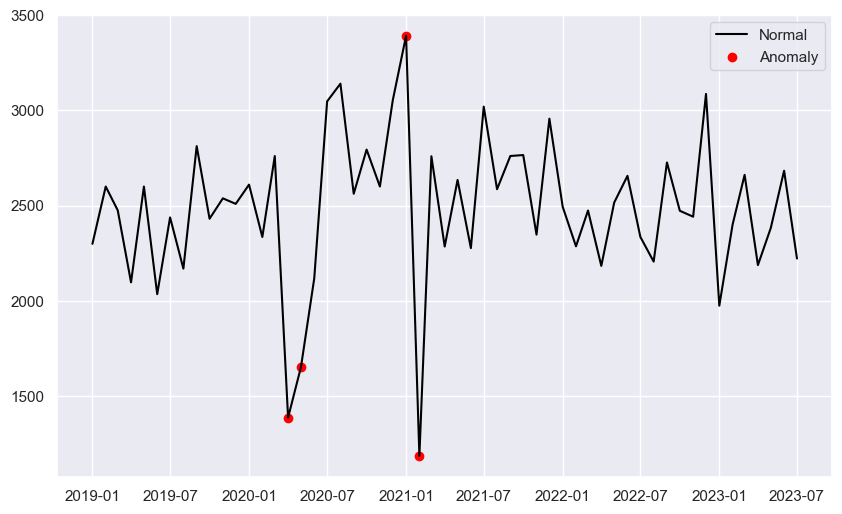

In [17]:
outliers_fraction = float(.06)
df_out=df_out.dropna()
#scaler = StandardScaler()
#np_scaled = scaler.fit_transform(df.values.reshape(-1, 1))
#data = pd.DataFrame(np_scaled)
# train isolation forest
model =  IsolationForest(contamination=outliers_fraction)
model.fit(df_out)

df['anomaly'] = model.predict(df_out)
df
# visualization
fig, ax = plt.subplots(figsize=(10,6))
a = df.loc[df['anomaly'] == -1, ['VENTA SELL IN']] #anomaly
ax.plot(df.index, df['VENTA SELL IN'], color='black', label = 'Normal')
ax.scatter(a.index,a['VENTA SELL IN'], color='red', label = 'Anomaly')
plt.legend()
plt.show()


In [5]:
#Ejecutar Pruebas de hipotesis a df normal
print(adf_test(df["VENTA SELL IN"]))
print(kpss_test(df["VENTA SELL IN"]))
#print(Johan_test(df[cols_data]))
print(grangres_test(df,'VENTA SELL IN',cols_data,6))


Results of Dickey-Fuller Test:
Test Statistic                -7.764851e+00
p-value                        9.246354e-12
#Lags Used                     0.000000e+00
Number of Observations Used    5.400000e+01
Critical Value (1%)           -3.557709e+00
Critical Value (5%)           -2.916770e+00
Critical Value (10%)          -2.596222e+00
dtype: float64
None
Results of KPSS Test:
Test Statistic           0.089077
p-value                  0.100000
Lags Used                0.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
None
Results Grangers Causality test:
VENTA SELL OUT TOTAL

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4516  , p=0.5046  , df_denom=51, df_num=1
ssr based chi2 test:   chi2=0.4782  , p=0.4892  , df=1
likelihood ratio test: chi2=0.4761  , p=0.4902  , df=1
parameter F test:         F=0.4516  , p=0.5046  , df_denom=51, df_num=1

Grange

C:\Users\Usuario\AppData\Local\Temp\ipykernel_19364\2721452478.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression='c')


True

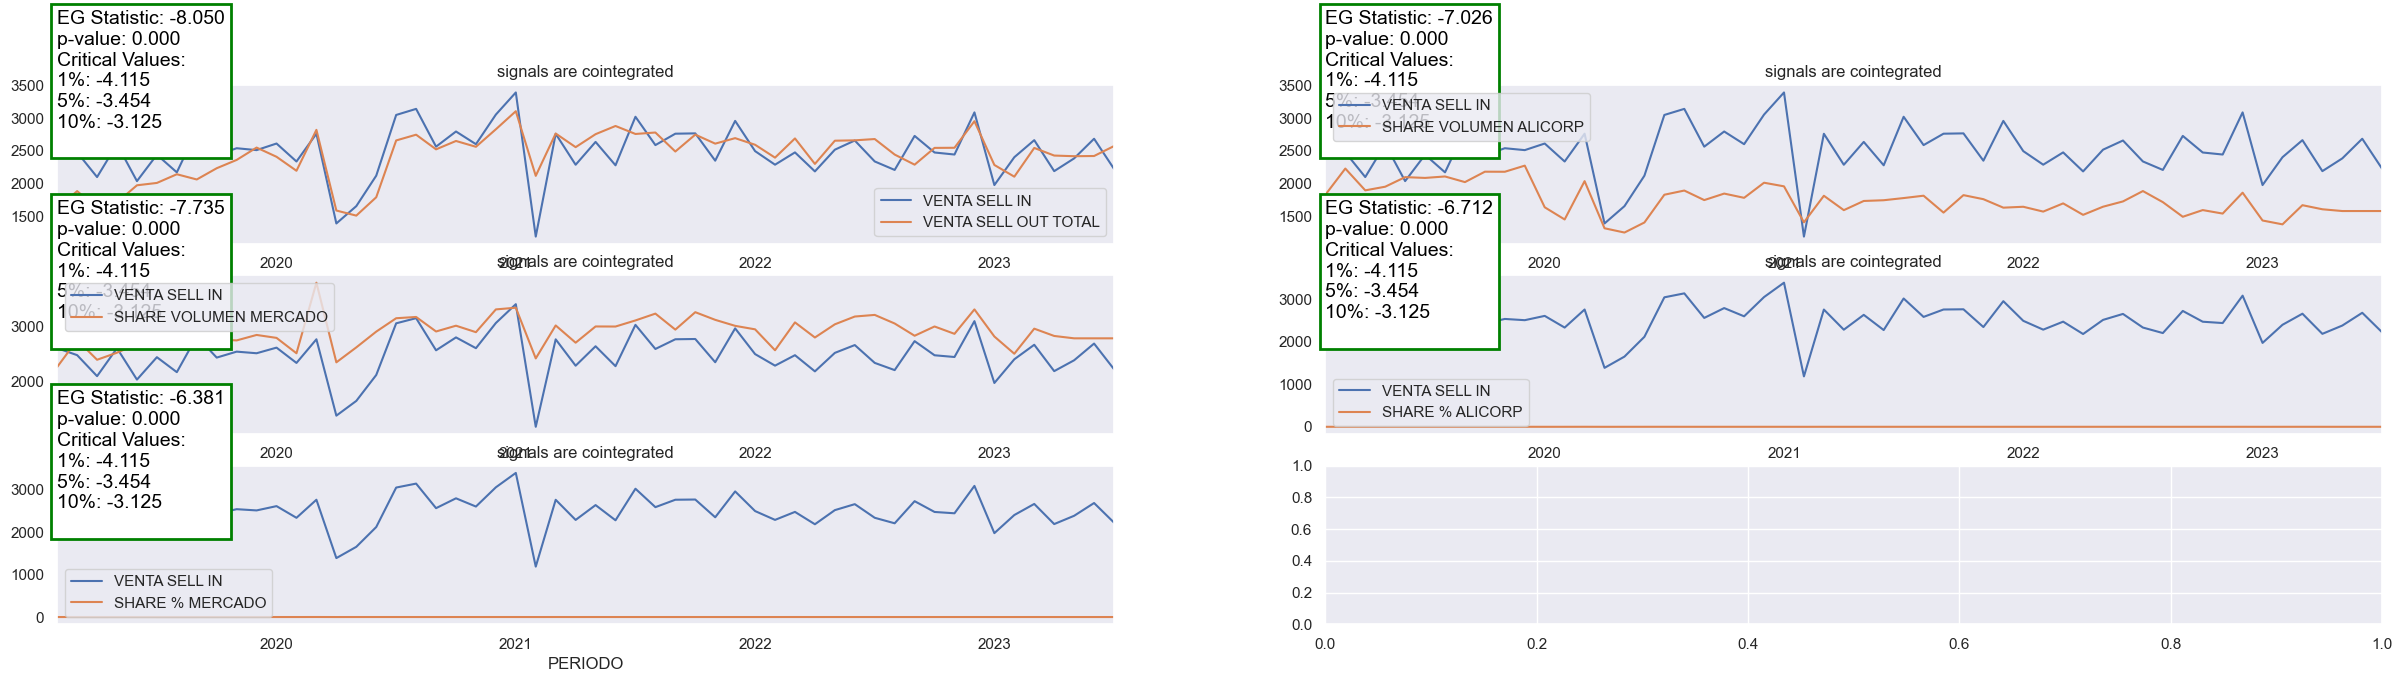

In [18]:
#Prueba COIntegración johansen
df_ini=df
df_ini.isna().values.any()
if df_ini.isna().values.any() == True:
    df_ini=df_ini.dropna()
else:
    df_ini=df_ini

plt.rcParams["figure.figsize"] = (30,7)
fig, axs = plt.subplots(3, 2)

plot_eg_stat_test(df_ini['VENTA SELL IN'],df_ini['VENTA SELL OUT TOTAL'], axs[0,0])
plot_eg_stat_test(df_ini['VENTA SELL IN'],df_ini['SHARE VOLUMEN ALICORP'], axs[0,1])
plot_eg_stat_test(df_ini['VENTA SELL IN'],df_ini['SHARE VOLUMEN MERCADO'], axs[1,0])
plot_eg_stat_test(df_ini['VENTA SELL IN'],df_ini['SHARE % ALICORP'], axs[1,1])
plot_eg_stat_test(df_ini['VENTA SELL IN'],df_ini['SHARE % MERCADO'], axs[2,0])
plt.show()

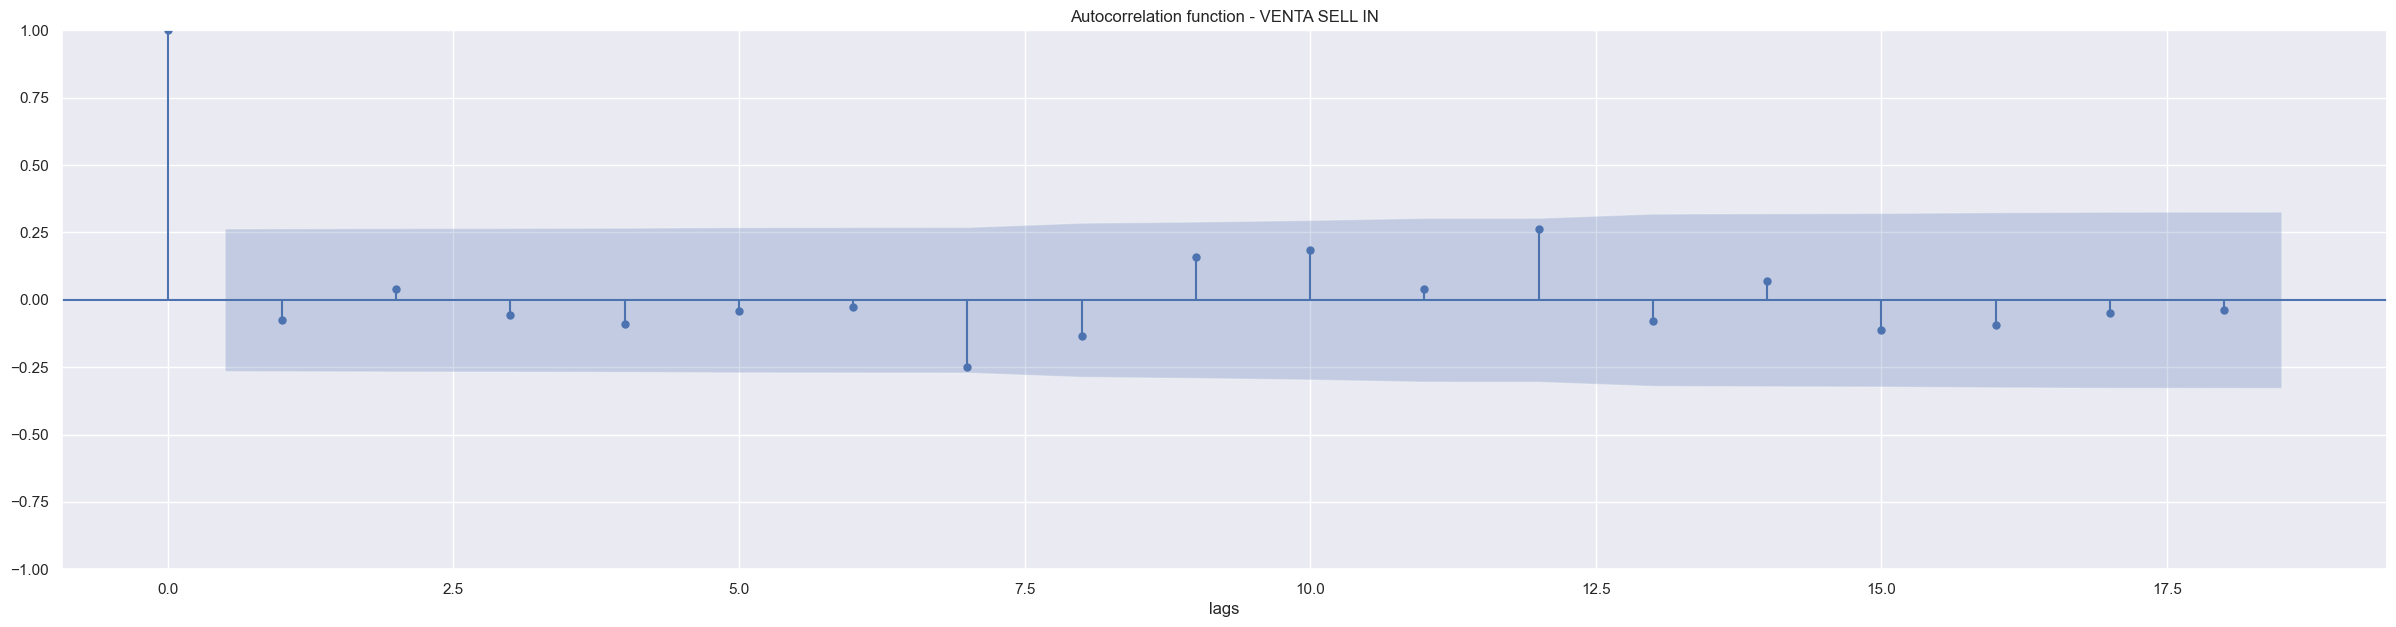

Time series "VENTA SELL IN" is stationay (NULL HP rejected - pvalue = 0.0000)


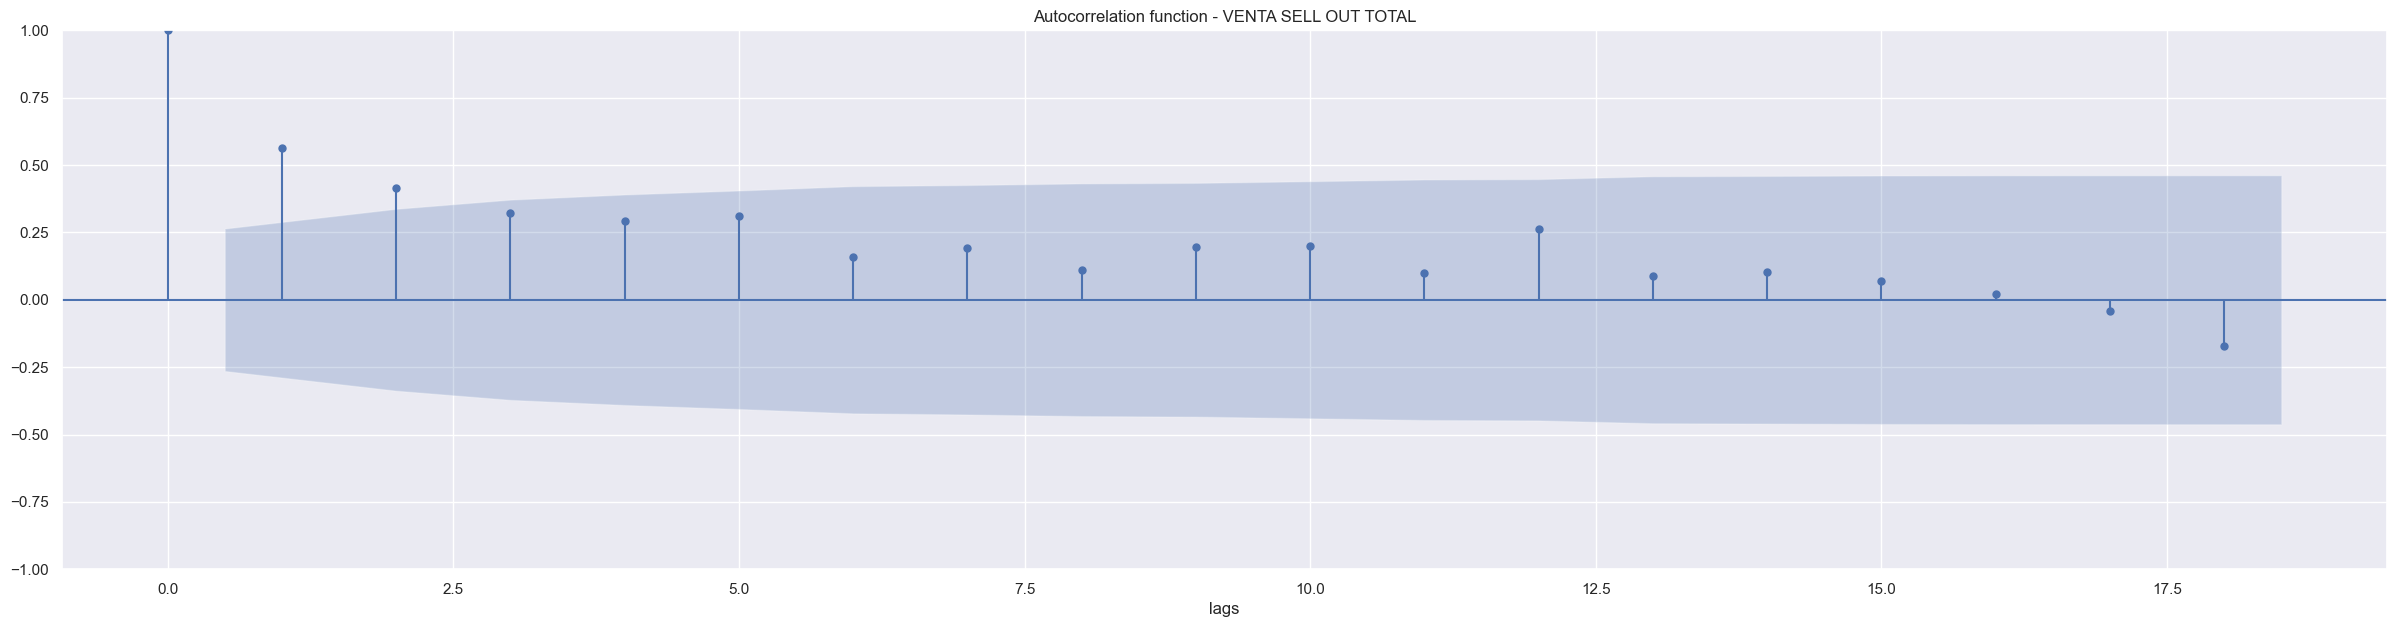

Time series "VENTA SELL OUT TOTAL" is stationay (NULL HP rejected - pvalue = 0.0018)


In [7]:
#Prueba de Hipótesis de Estacionaridad
stationary_test(df,cols_data,)

In [8]:
#Ejecutar Pruebas de hipotesis a df diff primer orden
df_PH= df[cols_data]
df_PH_diff_1=df_PH.diff()
df_PH_diff_1= df_PH_diff_1.dropna()

print(adf_test(df_PH_diff_1["VENTA SELL IN"]))
print(kpss_test(df_PH_diff_1["VENTA SELL IN"]))
print(Johan_test(df_PH_diff_1[cols_data]))
print(grangres_test(df_PH_diff_1,'VENTA SELL IN',cols_data,6))

Results of Dickey-Fuller Test:
Test Statistic                 -4.695579
p-value                         0.000086
#Lags Used                     10.000000
Number of Observations Used    43.000000
Critical Value (1%)            -3.592504
Critical Value (5%)            -2.931550
Critical Value (10%)           -2.604066
dtype: float64
None
Results of KPSS Test:
Test Statistic            0.192324
p-value                   0.100000
Lags Used                16.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
None
Results of Johan Cointegration test:
eig: [0.62895695 0.48749301]
max_eig_stat: [51.55473318 34.75892814]
max_eig_stat_crit_vals: [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]]
trace_stat: [86.31366132 34.75892814]
trace_stat_crit_vals: [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]]
None
Results Grangers Causality test:
VENTA SELL OUT TOTAL

Granger Causali

C:\Users\Usuario\AppData\Local\Temp\ipykernel_19364\2721452478.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression='c')


In [9]:
#Ejecutar Pruebas de hipotesis a df diff seg orden
df_PH_diff_2=df_PH_diff_1.diff().dropna()

print(adf_test(df_PH_diff_2["VENTA SELL IN"]))
print(kpss_test(df_PH_diff_2["VENTA SELL IN"]))
print(Johan_test(df_PH_diff_2[cols_data]))
print(grangres_test(df_PH_diff_2,'VENTA SELL IN',cols_data,6))

Results of Dickey-Fuller Test:
Test Statistic                 -4.561301
p-value                         0.000152
#Lags Used                     11.000000
Number of Observations Used    41.000000
Critical Value (1%)            -3.600983
Critical Value (5%)            -2.935135
Critical Value (10%)           -2.605963
dtype: float64
None
Results of KPSS Test:
Test Statistic            0.094086
p-value                   0.100000
Lags Used                10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
None
Results of Johan Cointegration test:
eig: [0.73406288 0.61832383]
max_eig_stat: [67.54926416 49.12232047]
max_eig_stat_crit_vals: [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]]
trace_stat: [116.67158463  49.12232047]
trace_stat_crit_vals: [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]]
None
Results Grangers Causality test:
VENTA SELL OUT TOTAL

Granger Causa

C:\Users\Usuario\AppData\Local\Temp\ipykernel_19364\2721452478.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression='c')


<Axes: xlabel='PERIODO'>

Text(0.5, 1.0, 'VENTA SELL IN')

<Axes: xlabel='PERIODO'>

Text(0.5, 1.0, 'VENTA SELL OUT TOTAL')

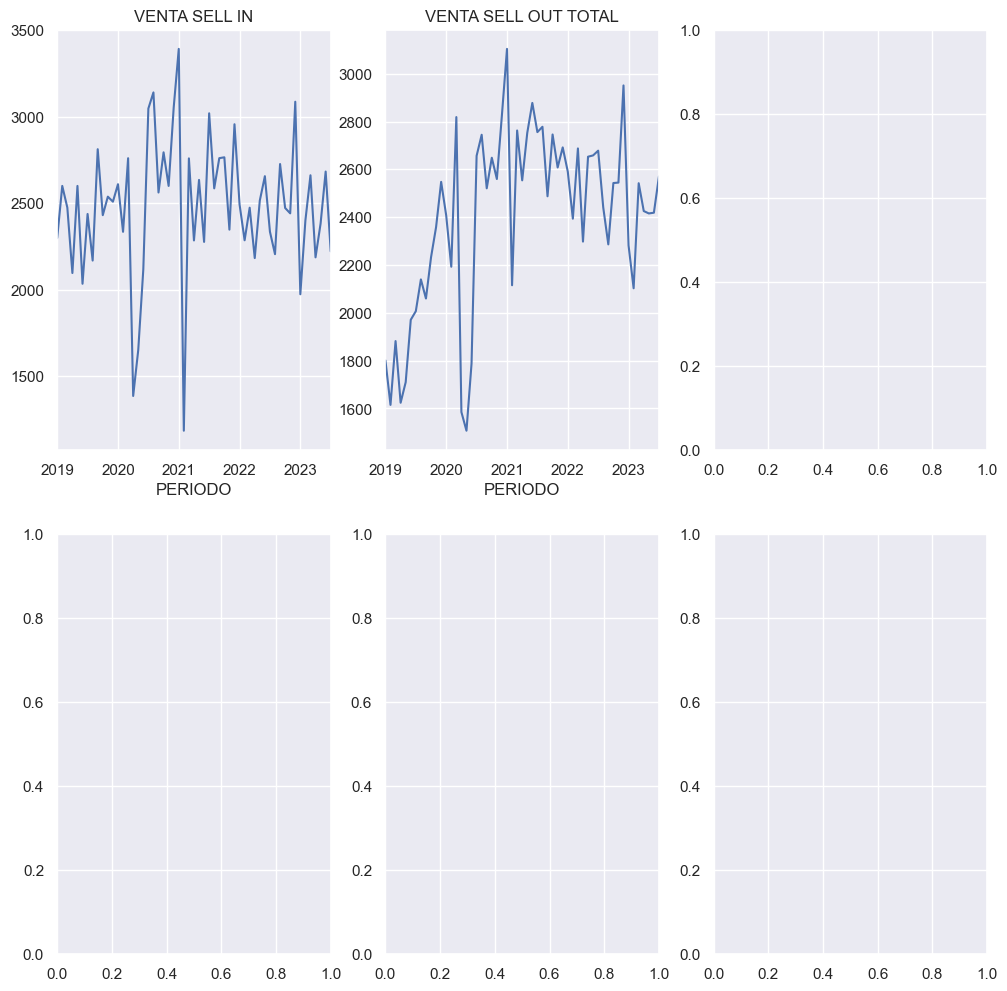

In [10]:
# Gráfico:Series de tiempo por variables
fig, ax = plt.subplots(2, 3, figsize=(12,12))
for idx, col in enumerate(df[cols_data].columns):
    df[col].plot(ax=ax.flatten()[idx])
    ax.flatten()[idx].set_title(col)

<Axes: ylabel='Count'>

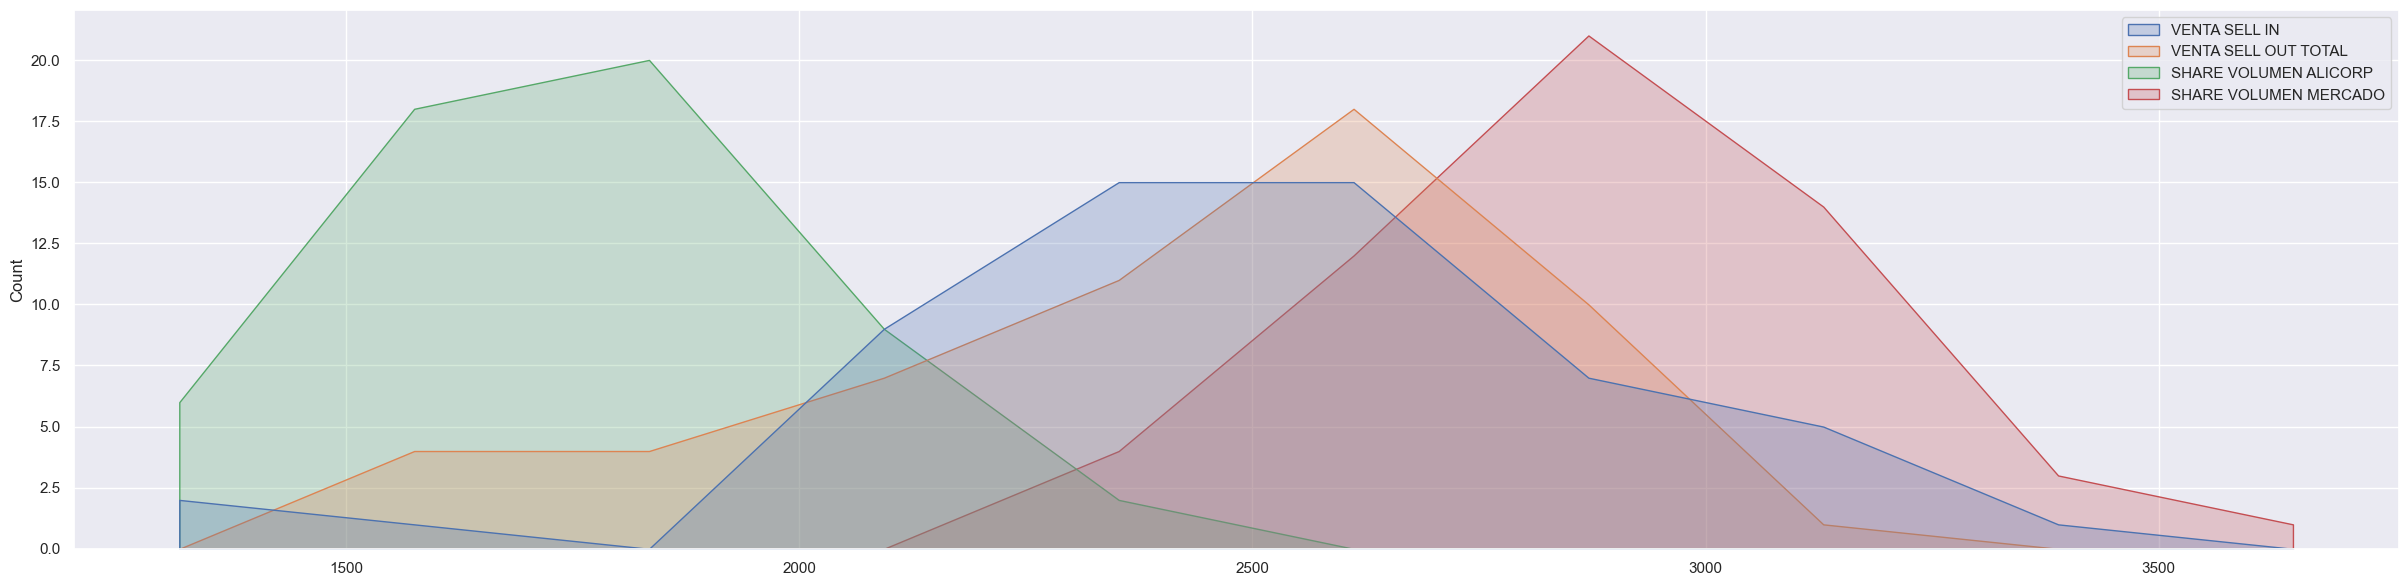

<Axes: ylabel='Count'>

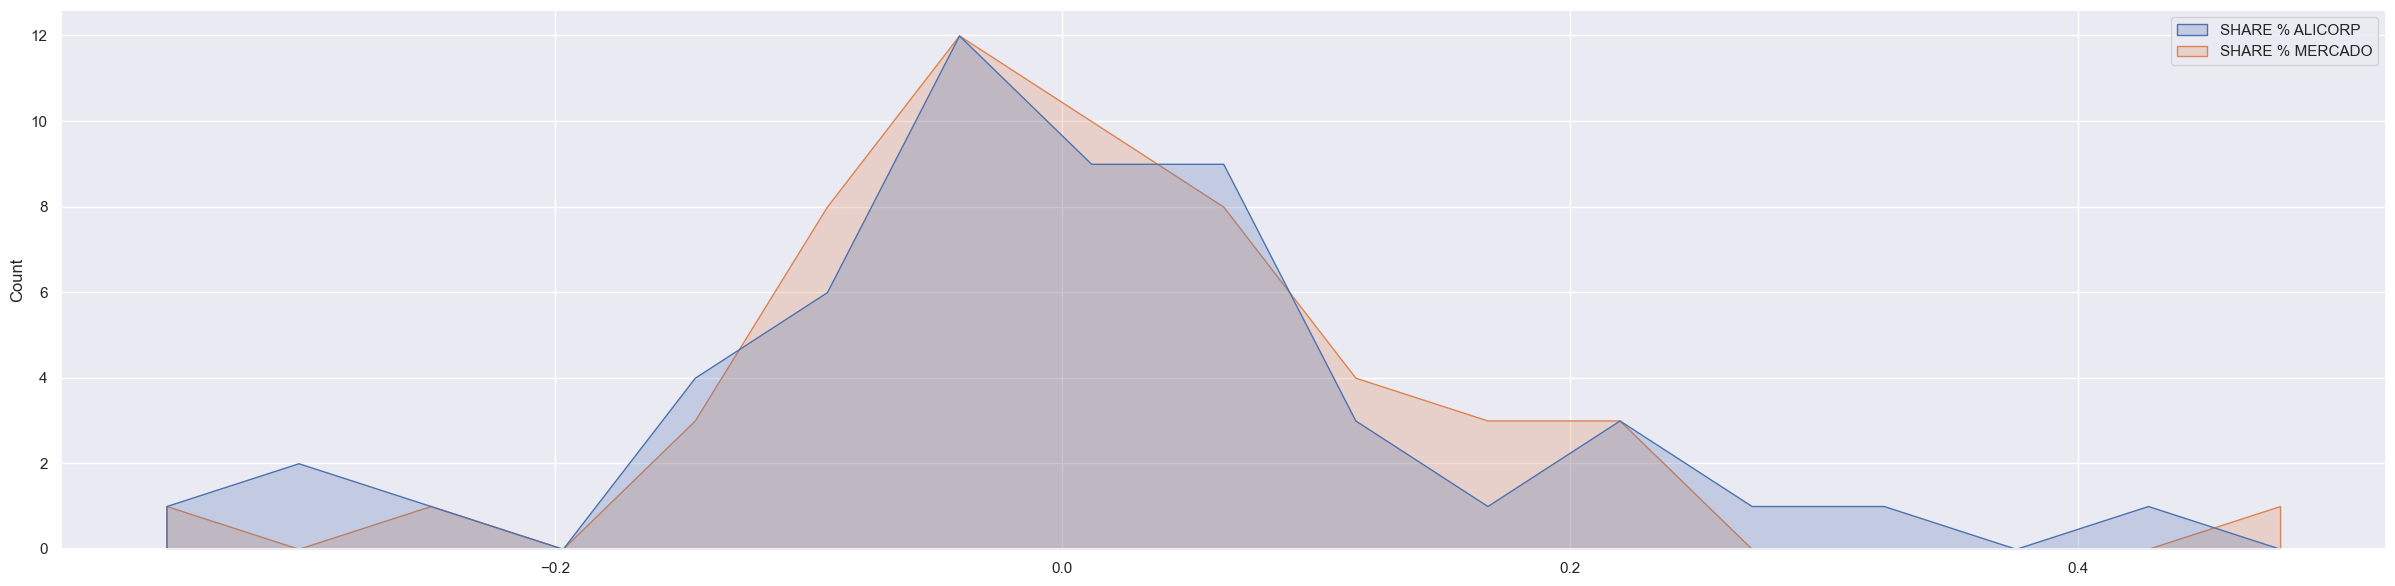

In [11]:
#HISTOGRAMAS
sns.histplot(data=df[["VENTA SELL IN","VENTA SELL OUT TOTAL","SHARE VOLUMEN ALICORP",'SHARE VOLUMEN MERCADO']],element="poly")
plt.show()
sns.histplot(data=df[['SHARE % ALICORP',"SHARE % MERCADO"]],element="poly")
plt.show()

<Axes: xlabel='PERIODO'>

<Axes: xlabel='PERIODO'>

<Axes: xlabel='PERIODO'>

<Axes: xlabel='PERIODO'>

Text(0.5, 1.0, 'VENTA SELL IN')

<Axes: xlabel='PERIODO'>

<Axes: xlabel='PERIODO'>

<Axes: xlabel='PERIODO'>

<Axes: xlabel='PERIODO'>

Text(0.5, 1.0, 'VENTA SELL OUT TOTAL')

<Axes: xlabel='PERIODO'>

<Axes: xlabel='PERIODO'>

<Axes: xlabel='PERIODO'>

<Axes: xlabel='PERIODO'>

Text(0.5, 1.0, 'SHARE VOLUMEN ALICORP')

<Axes: xlabel='PERIODO'>

<Axes: xlabel='PERIODO'>

<Axes: xlabel='PERIODO'>

<Axes: xlabel='PERIODO'>

Text(0.5, 1.0, 'SHARE VOLUMEN MERCADO')

<Axes: xlabel='PERIODO'>

<Axes: xlabel='PERIODO'>

<Axes: xlabel='PERIODO'>

<Axes: xlabel='PERIODO'>

Text(0.5, 1.0, 'SHARE % ALICORP')

<Axes: xlabel='PERIODO'>

<Axes: xlabel='PERIODO'>

<Axes: xlabel='PERIODO'>

<Axes: xlabel='PERIODO'>

Text(0.5, 1.0, 'SHARE % MERCADO')

Text(0.5, 0.98, 'Moving average plot')

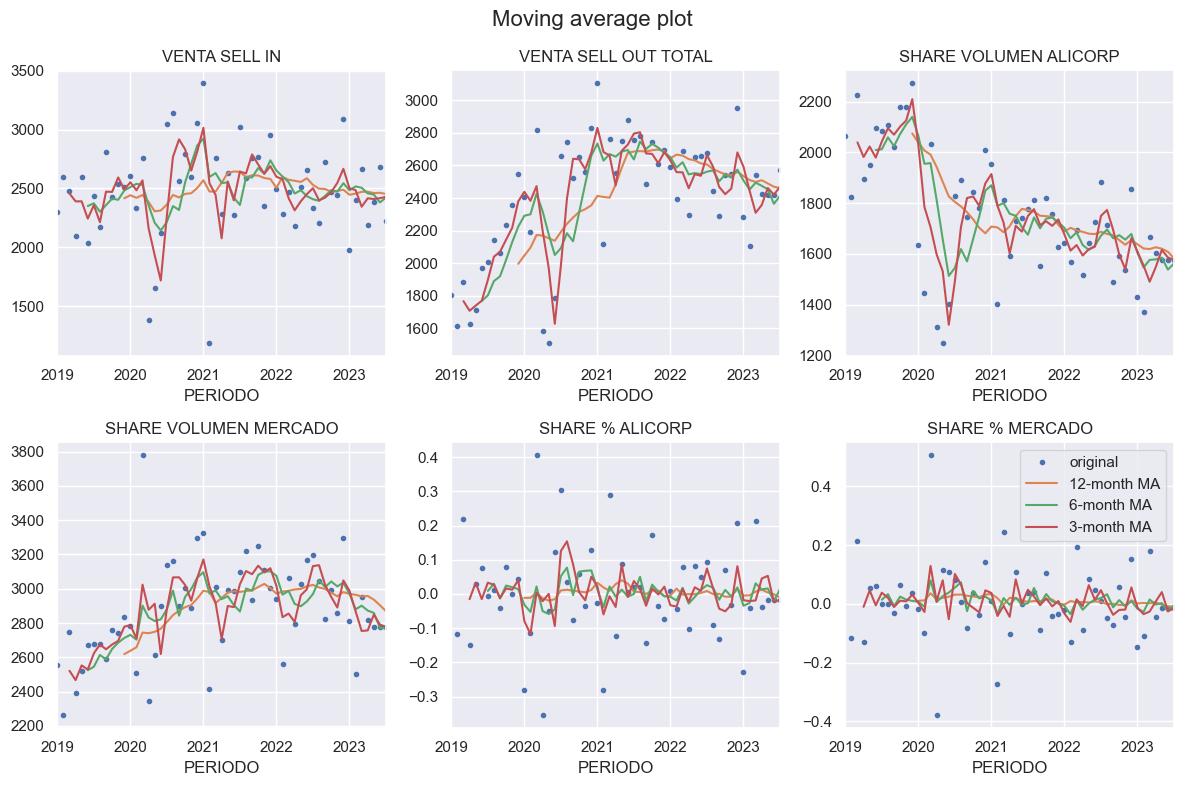

In [12]:
# Gráfico:Ver Tendencias con Movil Average
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
for idx, col in enumerate(['VENTA SELL IN', 'VENTA SELL OUT TOTAL', 'SHARE VOLUMEN ALICORP', 'SHARE VOLUMEN MERCADO','SHARE % ALICORP','SHARE % MERCADO']):
    df[col].plot(ax=ax.flatten()[idx], style=".", label="original")
    df[col].rolling(12).mean().plot(ax=ax.flatten()[idx], label="12-month MA")
    df[col].rolling(6).mean().plot(ax=ax.flatten()[idx], label="6-month MA")
    df[col].rolling(3).mean().plot(ax=ax.flatten()[idx], label="3-month MA")
    ax.flatten()[idx].set_title(col)
plt.legend()
plt.suptitle("Moving average plot", fontsize=16)
plt.tight_layout()

<Axes: xlabel='MES', ylabel='VENTA SELL IN'>

Text(0.5, 1.0, 'VENTA SELL IN')

<Axes: xlabel='MES', ylabel='VENTA SELL OUT TOTAL'>

Text(0.5, 1.0, 'VENTA SELL OUT TOTAL')

<Axes: xlabel='MES', ylabel='SHARE VOLUMEN ALICORP'>

Text(0.5, 1.0, 'SHARE VOLUMEN ALICORP')

<Axes: xlabel='MES', ylabel='SHARE VOLUMEN MERCADO'>

Text(0.5, 1.0, 'SHARE VOLUMEN MERCADO')

<Axes: xlabel='MES', ylabel='SHARE % ALICORP'>

Text(0.5, 1.0, 'SHARE % ALICORP')

<Axes: xlabel='MES', ylabel='SHARE % MERCADO'>

Text(0.5, 1.0, 'SHARE % MERCADO')

Text(0.5, 0.98, 'Data changes by month')

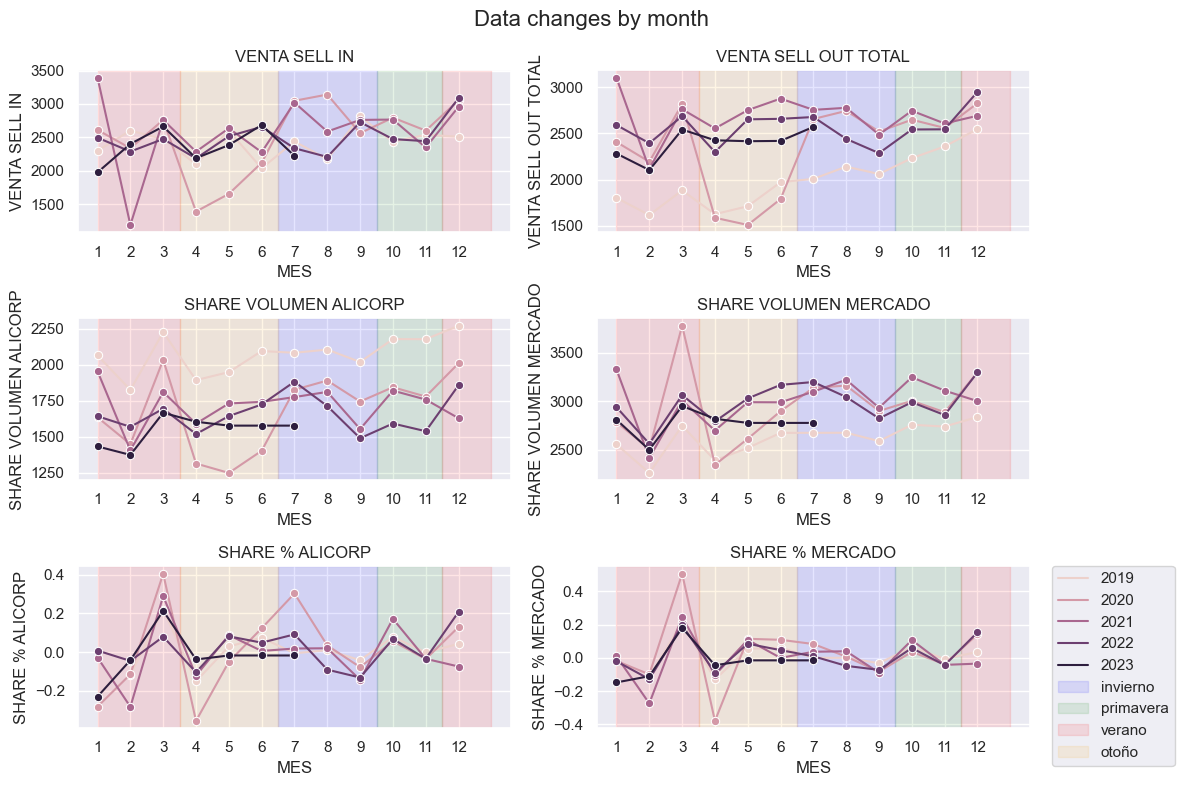

In [13]:
# Gráfico: Ver Estacionalidad por estación climática
fig, ax = plt.subplots(3, 2, figsize=(12, 8))
for idx, col in enumerate(['VENTA SELL IN', 'VENTA SELL OUT TOTAL', 'SHARE VOLUMEN ALICORP', 'SHARE VOLUMEN MERCADO','SHARE % ALICORP','SHARE % MERCADO']):
    sns.lineplot(x='MES', y=col, data=df_todo, hue='AÑO', marker='o', ax=ax.flatten()[idx])
    ax.flatten()[idx].set_title(col)
    # not show the legend
    ax.flatten()[idx].get_legend().remove()
    ax.flatten()[idx].set_xticks(range(1, 13))
    # plot color shade as season (winter, spring, summer, autumn)
    ax.flatten()[idx].axvspan(6.5, 9.5, alpha=0.1, color='blue', label='invierno')
    ax.flatten()[idx].axvspan(9.5, 11.5, alpha=0.1, color='green', label='primavera')
    ax.flatten()[idx].axvspan(1, 3.5, alpha=0.1, color='red', label='verano')
    ax.flatten()[idx].axvspan(11.5, 13, alpha=0.1, color='red')
    ax.flatten()[idx].axvspan(3.5, 6.5, alpha=0.1, color='orange', label='otoño')
# add legend on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.suptitle("Data changes by month", fontsize=16)
plt.tight_layout()

<Axes: xlabel='Quarter', ylabel='VENTA SELL IN'>

Text(0.5, 1.0, 'VENTA SELL IN')

<Axes: xlabel='Quarter', ylabel='VENTA SELL OUT TOTAL'>

Text(0.5, 1.0, 'VENTA SELL OUT TOTAL')

<Axes: xlabel='Quarter', ylabel='SHARE VOLUMEN ALICORP'>

Text(0.5, 1.0, 'SHARE VOLUMEN ALICORP')

<Axes: xlabel='Quarter', ylabel='SHARE VOLUMEN MERCADO'>

Text(0.5, 1.0, 'SHARE VOLUMEN MERCADO')

<Axes: xlabel='Quarter', ylabel='SHARE % ALICORP'>

Text(0.5, 1.0, 'SHARE % ALICORP')

<Axes: xlabel='Quarter', ylabel='SHARE % MERCADO'>

Text(0.5, 1.0, 'SHARE % MERCADO')

Text(0.5, 0.98, 'Data changes by Quarter')

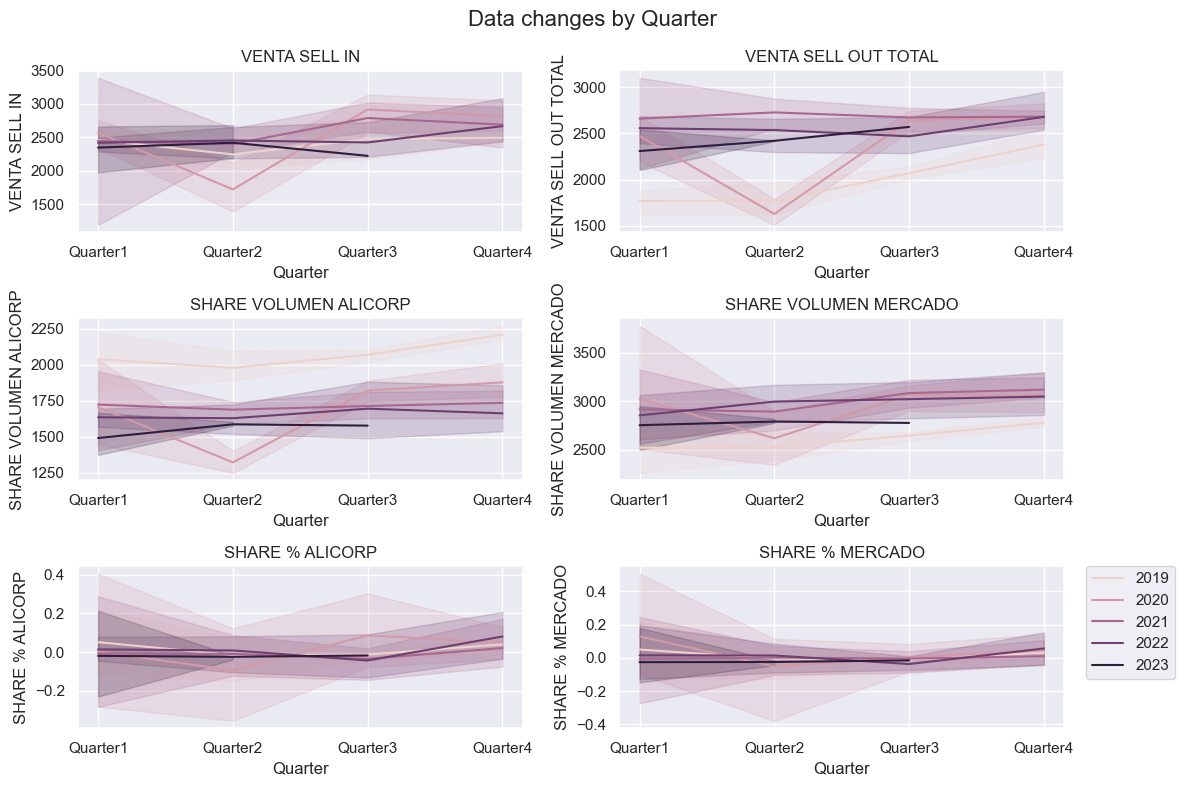

In [14]:
# Gráfico:Ver Estacionalidad por quatrimestre

fig, ax = plt.subplots(3, 2, figsize=(12, 8))
for idx, col in enumerate(['VENTA SELL IN', 'VENTA SELL OUT TOTAL', 'SHARE VOLUMEN ALICORP', 'SHARE VOLUMEN MERCADO','SHARE % ALICORP','SHARE % MERCADO']):
    sns.lineplot(x='Quarter', y=col, data=df_todo, hue='AÑO', ax=ax.flatten()[idx])
    ax.flatten()[idx].set_title(col)
    # not show the legend
    ax.flatten()[idx].get_legend().remove()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.suptitle("Data changes by Quarter", fontsize=16)
plt.tight_layout()

<Axes: xlabel='Month_in_Quarter', ylabel='VENTA SELL IN'>

Text(0.5, 1.0, 'VENTA SELL IN')

[Text(1, 0, '1st'), Text(2, 0, '2nd'), Text(3, 0, '3rd')]

<Axes: xlabel='Month_in_Quarter', ylabel='VENTA SELL OUT TOTAL'>

Text(0.5, 1.0, 'VENTA SELL OUT TOTAL')

[Text(1, 0, '1st'), Text(2, 0, '2nd'), Text(3, 0, '3rd')]

<Axes: xlabel='Month_in_Quarter', ylabel='SHARE VOLUMEN ALICORP'>

Text(0.5, 1.0, 'SHARE VOLUMEN ALICORP')

[Text(1, 0, '1st'), Text(2, 0, '2nd'), Text(3, 0, '3rd')]

<Axes: xlabel='Month_in_Quarter', ylabel='SHARE VOLUMEN MERCADO'>

Text(0.5, 1.0, 'SHARE VOLUMEN MERCADO')

[Text(1, 0, '1st'), Text(2, 0, '2nd'), Text(3, 0, '3rd')]

<Axes: xlabel='Month_in_Quarter', ylabel='SHARE % ALICORP'>

Text(0.5, 1.0, 'SHARE % ALICORP')

[Text(1, 0, '1st'), Text(2, 0, '2nd'), Text(3, 0, '3rd')]

<Axes: xlabel='Month_in_Quarter', ylabel='SHARE % MERCADO'>

Text(0.5, 1.0, 'SHARE % MERCADO')

[Text(1, 0, '1st'), Text(2, 0, '2nd'), Text(3, 0, '3rd')]

Text(0.5, 0.98, 'Data changes by month in each Quarter')

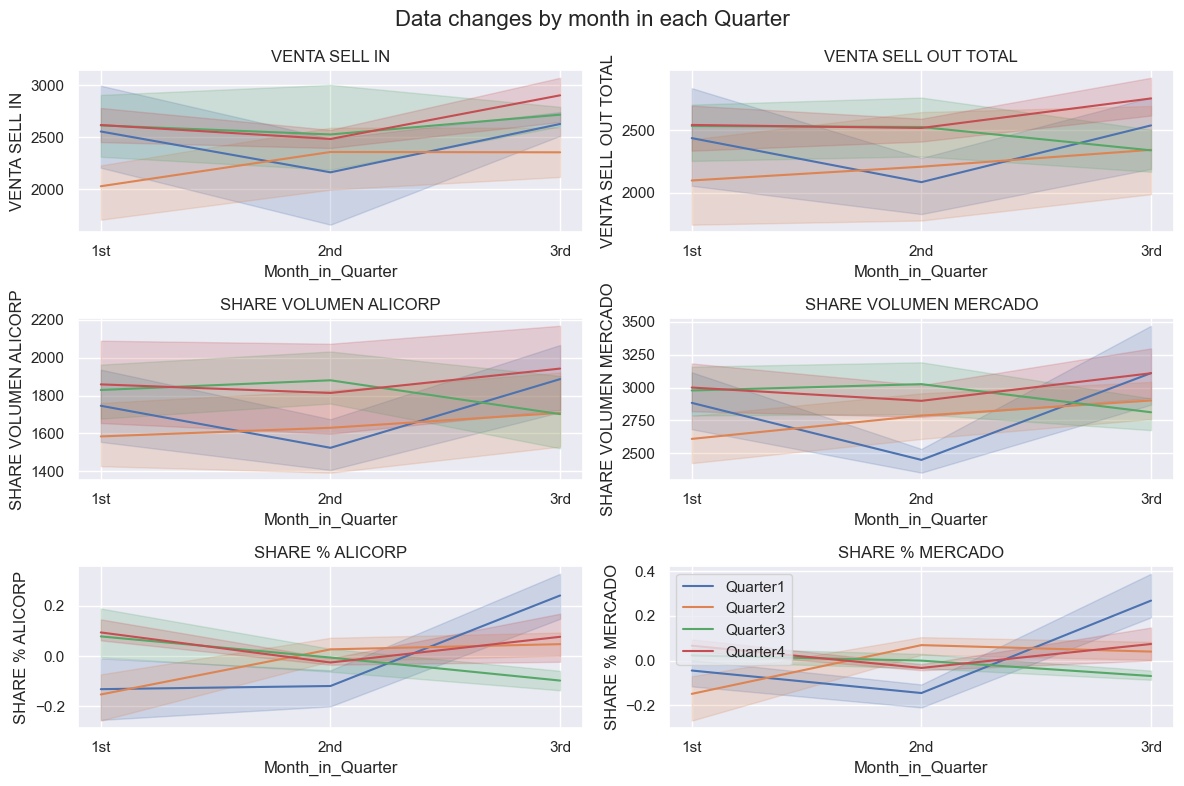

In [15]:
# Gráfico:Ver Estacionalidad por mes de trimestre
fig, ax = plt.subplots(3, 2, figsize=(12, 8))
for idx, col in enumerate(['VENTA SELL IN', 'VENTA SELL OUT TOTAL', 'SHARE VOLUMEN ALICORP', 'SHARE VOLUMEN MERCADO','SHARE % ALICORP','SHARE % MERCADO']):
    sns.lineplot(x='Month_in_Quarter', y=col, data=df_todo, hue='Quarter', ax=ax.flatten()[idx], errorbar=('ci', 95))
    ax.flatten()[idx].set_title(col)
    # not show the legend
    ax.flatten()[idx].get_legend().remove()
    ax.flatten()[idx].set_xticks([1, 2, 3])
    ax.flatten()[idx].set_xticklabels(['1st', '2nd', '3rd'])
plt.legend()
plt.suptitle("Data changes by month in each Quarter", fontsize=16)
plt.tight_layout()

[0.         0.21818182 0.43636364 0.65454545 0.87272727 1.09090909
 1.30909091 1.52727273 1.74545455 1.96363636 2.18181818 2.4
 2.61818182 2.83636364 3.05454545 3.27272727 3.49090909 3.70909091
 3.92727273 4.14545455 4.36363636 4.58181818 4.8        5.01818182
 5.23636364 5.45454545 5.67272727 5.89090909] and [7.22073985e-26 5.81740637e+03 1.24855643e+03 4.10626569e+02
 8.84023144e+03 1.72763458e+04 6.31107298e+03 8.50096598e+02
 1.02049215e+03 1.26999043e+03 1.27518898e+04 4.53447546e+03
 1.00548656e+04 5.41368708e+03 1.18338693e+03 8.62057493e+02
 3.70473908e+02 1.00170062e+04 6.19312500e+03 1.50866792e+04
 1.78582804e+03 2.83370937e+03 3.47982204e+03 1.11447101e+04
 7.71507461e+03 3.44193361e+03 5.83978547e+02 1.45409839e+04]


[]

Text(0.5, 1.0, 'VENTA SELL IN')

[0.         0.21818182 0.43636364 0.65454545 0.87272727 1.09090909
 1.30909091 1.52727273 1.74545455 1.96363636 2.18181818 2.4
 2.61818182 2.83636364 3.05454545 3.27272727 3.49090909 3.70909091
 3.92727273 4.14545455 4.36363636 4.58181818 4.8        5.01818182
 5.23636364 5.45454545 5.67272727 5.89090909] and [1.53814577e-26 5.56501489e+04 3.74606805e+03 7.14131224e+03
 1.01050171e+04 9.76162383e+03 1.39279203e+03 4.06699114e+03
 5.46451903e+03 1.86045423e+03 6.93955542e+03 1.81279625e+03
 5.06949568e+03 7.23123879e+02 5.06895499e+03 1.44267773e+03
 4.93716073e+02 2.91169860e+03 4.26926870e+03 2.59495576e+02
 1.96151586e+02 5.26635457e+02 1.25107320e+03 9.37109136e+03
 9.52968965e+02 4.81421907e+02 9.10706289e+02 1.47450458e+03]


[]

Text(0.5, 1.0, 'VENTA SELL OUT TOTAL')

[0.         0.21818182 0.43636364 0.65454545 0.87272727 1.09090909
 1.30909091 1.52727273 1.74545455 1.96363636 2.18181818 2.4
 2.61818182 2.83636364 3.05454545 3.27272727 3.49090909 3.70909091
 3.92727273 4.14545455 4.36363636 4.58181818 4.8        5.01818182
 5.23636364 5.45454545 5.67272727 5.89090909] and [1.70905085e-27 8.86734623e+03 9.95418070e+03 8.63588720e+03
 1.39640258e+03 4.82582556e+03 1.67903848e+03 5.94057297e+02
 1.37193558e+02 1.91978200e+02 7.27421431e+02 8.04723285e+00
 5.20972318e+03 1.09915953e+03 2.87863084e+03 4.42732721e+02
 2.95498993e+02 1.25334637e+03 1.33294499e+03 3.06998982e+02
 5.09047321e+02 1.03989404e+03 1.61441106e+02 5.41362302e+03
 8.48766563e+01 4.18143165e+02 1.48608067e+02 7.65367847e+02]


[]

Text(0.5, 1.0, 'SHARE VOLUMEN ALICORP')

[0.         0.21818182 0.43636364 0.65454545 0.87272727 1.09090909
 1.30909091 1.52727273 1.74545455 1.96363636 2.18181818 2.4
 2.61818182 2.83636364 3.05454545 3.27272727 3.49090909 3.70909091
 3.92727273 4.14545455 4.36363636 4.58181818 4.8        5.01818182
 5.23636364 5.45454545 5.67272727 5.89090909] and [3.93765316e-26 1.90216353e+04 4.38037095e+03 6.36554494e+02
 6.63656554e+02 3.62600458e+03 2.02357879e+03 1.46561932e+02
 8.61193223e+02 1.05139762e+03 3.41267392e+03 1.51199342e+03
 3.76277265e+03 1.60125058e+03 3.13938997e+03 1.18299474e+03
 1.32106703e+03 1.97714370e+03 6.39046285e+03 3.74390099e+02
 8.91180042e+02 2.07872085e+02 1.46919285e+03 1.56900370e+04
 3.98342698e+02 5.73719767e+02 2.19261559e+02 3.07800849e+03]


[]

Text(0.5, 1.0, 'SHARE VOLUMEN MERCADO')

[0.         0.21818182 0.43636364 0.65454545 0.87272727 1.09090909
 1.30909091 1.52727273 1.74545455 1.96363636 2.18181818 2.4
 2.61818182 2.83636364 3.05454545 3.27272727 3.49090909 3.70909091
 3.92727273 4.14545455 4.36363636 4.58181818 4.8        5.01818182
 5.23636364 5.45454545 5.67272727 5.89090909] and [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]


[Text(1, 0, 'Annual (1)'),
 Text(2, 0, 'Semiannual (2)'),
 Text(3, 0, 'Triannual (3)'),
 Text(4, 0, 'Quarterly (4)'),
 Text(6, 0, 'Bimonthly (6)')]

Text(0.5, 1.0, 'SHARE % ALICORP')

[0.         0.21818182 0.43636364 0.65454545 0.87272727 1.09090909
 1.30909091 1.52727273 1.74545455 1.96363636 2.18181818 2.4
 2.61818182 2.83636364 3.05454545 3.27272727 3.49090909 3.70909091
 3.92727273 4.14545455 4.36363636 4.58181818 4.8        5.01818182
 5.23636364 5.45454545 5.67272727 5.89090909] and [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]


[Text(1, 0, 'Annual (1)'),
 Text(2, 0, 'Semiannual (2)'),
 Text(3, 0, 'Triannual (3)'),
 Text(4, 0, 'Quarterly (4)'),
 Text(6, 0, 'Bimonthly (6)')]

Text(0.5, 1.0, 'SHARE % MERCADO')

Text(0.5, 0.98, 'Periodogram')

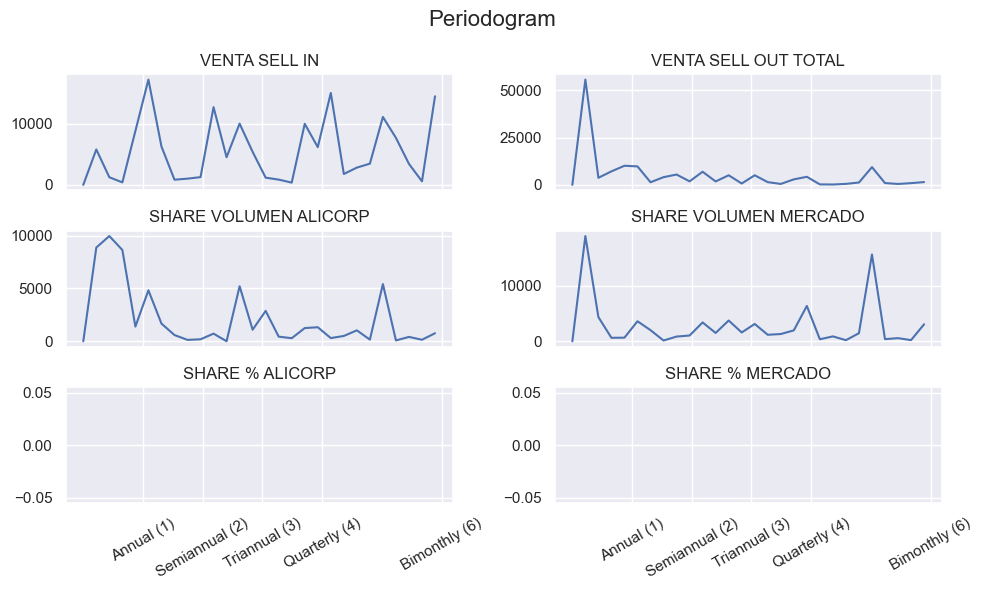

In [16]:
#Gráfico: Ver Periodograma
fig, ax = plt.subplots(3, 2, figsize=(10, 6), sharex=True, sharey=False)
for idx, col in enumerate(['VENTA SELL IN', 'VENTA SELL OUT TOTAL', 'SHARE VOLUMEN ALICORP', 'SHARE VOLUMEN MERCADO','SHARE % ALICORP','SHARE % MERCADO']):
    freq, spectrum = periodogram(df[col], fs=12,
                                    window="boxcar",
                                    scaling='spectrum')
    print(freq,'and',spectrum)
    ax.flatten()[idx].plot(freq, spectrum)
    ax.flatten()[idx].set_xticks([1, 2, 3, 4, 6])
    ax.flatten()[idx].set_xticklabels(
        [  "Annual (1)",
        "Semiannual (2)",
        "Triannual (3)",
        "Quarterly (4)",
        "Bimonthly (6)",
        ],
        rotation=30,
    )
    ax.flatten()[idx].set_title(col)
plt.suptitle("Periodogram", fontsize=16)
plt.tight_layout()